## Imports and Params

Setup the imports for the notebook and import the tatrec package locally

In [1]:
from pathlib import Path
import os
from fastai.vision import *
from fastai.metrics import error_rate

In [2]:
import sys
# Ensure tatrec package is in the path
sys.path.append(os.path.join(Path.cwd(), "..", "tatrec"))

In [8]:
from tatrec.notebook_funcs import (get_data_from_folder, print_data_classes_size, 
                                   plot_similar_tats)
from tatrec.config import (path_train_cnn, path_data_raw, 
                           path_models)

In [4]:
bs = 128   # batch size
arch = models.resnet50

## Setup the data

Setup the path to the images, caption, and label information. Create a DataBunch that is both the training and validation information wrapped in a class with transformations to be performed included.

In [3]:
tfms = get_transforms(flip_vert = False)

In [14]:
data = get_data_from_folder(path_train_cnn, bs, 64, tfms)

In [8]:
data

ImageDataBunch;

Train: LabelList (13356 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
notat,notat,notat,notat,notat
Path: /Users/bigtyme/data/raw/train;

Valid: LabelList (3339 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
notat,notat,notat,notat,notat
Path: /Users/bigtyme/data/raw/train;

Test: None

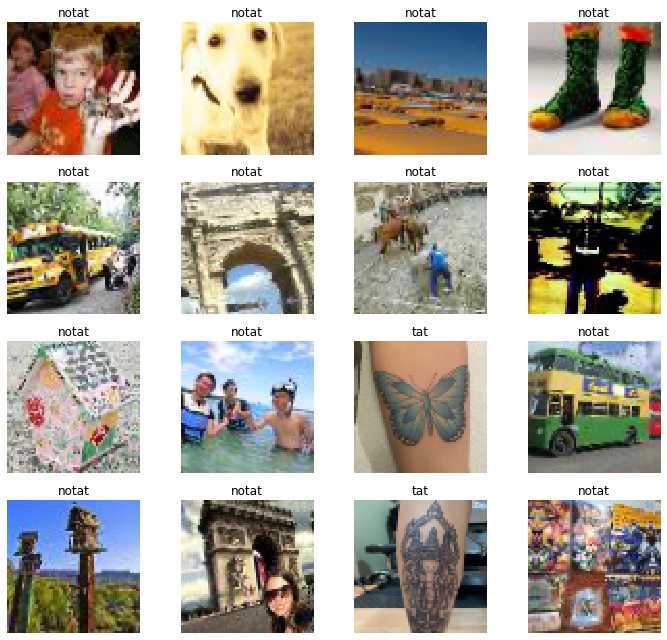

In [24]:
# show a batch to make sure the labels are correct and get
# an idea of for the types of images
data.show_batch(rows=4, figsize=(10,9),)

## Training the model

Use a ResNet50 CNN network architecture that the weights are pre-trained on ImageNet as the starting point to train the model. Error-rate metric is used to get the Top-1 score.

In [ ]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

Finds optimal learning rates to use during training.

In [ ]:
learn.lr_find()
learn.recorder.plot()

First, train the last fully connected layer with all other layers of the pre-trained ResNet50 model frozen.

In [12]:
learn.fit_one_cycle(3, max_lr=5e-3)

epoch,train_loss,valid_loss,error_rate,time
0,0.105943,0.068472,0.024558,04:47
1,0.036720,0.024809,0.007787,04:42
2,0.014541,0.025264,0.008386,04:39


In [13]:
learn.save(path_models/'tatrec-stage-1-1')

Unfreeze all layers of the ResNet50 model and continue training to fine-tune the network. The maximum learning rate is lowered after each cycle to further help fine-tune.

In [12]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(5e-5,5e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.029292,0.014415,0.003893,05:00
1,0.018301,0.007735,0.001797,04:55
2,0.008615,0.010797,0.002396,05:00


In [13]:
learn.save(path_models/'tatrec-stage-2-1')

## Results

We will first check to see if the model predictions for tattoo or no tattoo are resonable or not. Most the mistakes seem reasonable and for the whole validation set (3339 images), only 8 mistakes are made. Therefore, it is an indicator that the classifier is working correctly. 

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

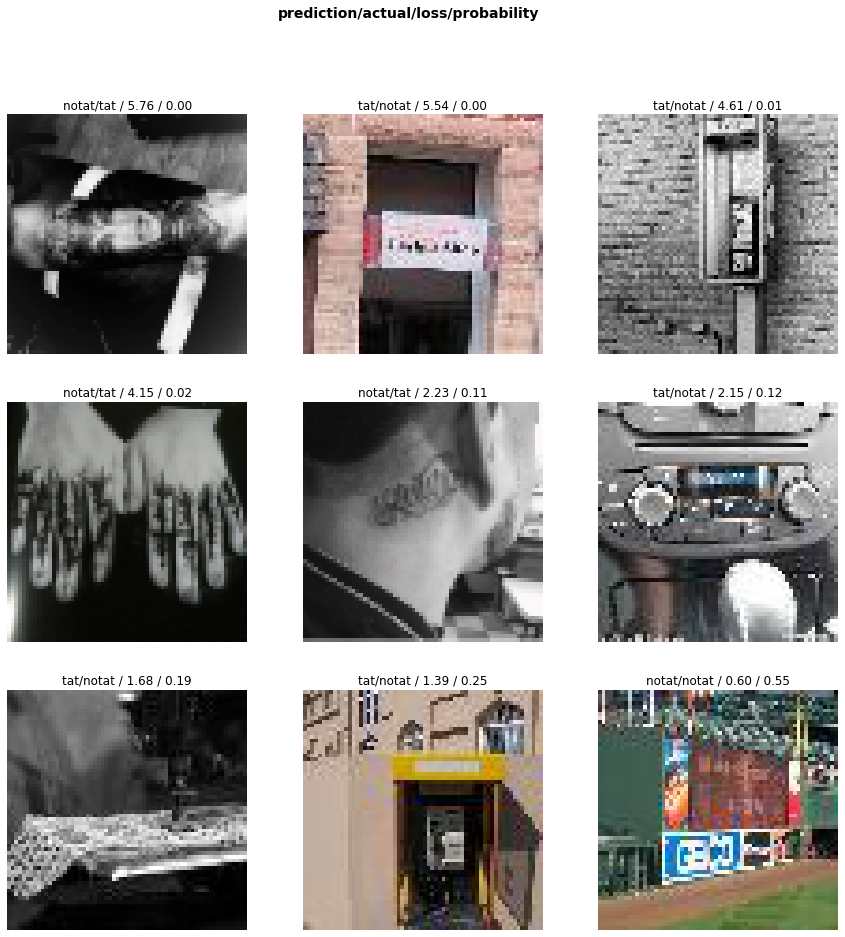

In [21]:
interp.plot_top_losses(9, figsize=(15,15))

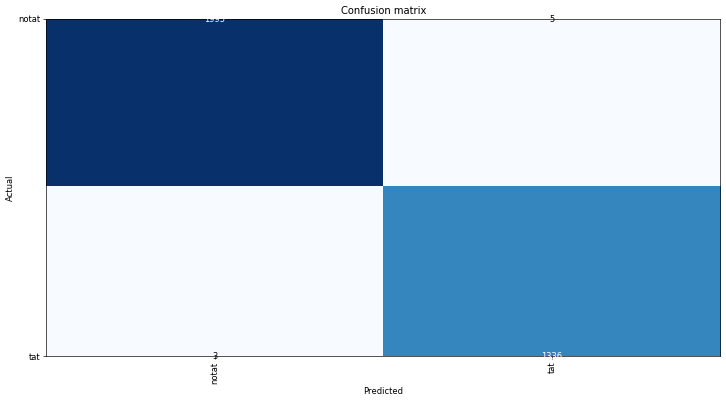

In [16]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [22]:
interp.most_confused(min_val=2)

[('notat', 'tat', 5), ('tat', 'notat', 3)]